## Deep Learning Course Project - Gesture Recognition

### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

-Thumbs up:  Increase the volume
-Thumbs down: Decrease the volume
-Left swipe: 'Jump' backwards 10 seconds
-Right swipe: 'Jump' forward 10 seconds  
-Stop: Pause the movie

Each video is a sequence of 30 frames (or images).

### Objectives:
1. **Generator**:  
The generator is able to successfully input a batch of videos to the model. Weightages have been allocated to the correct list creation of img_idx, initialization of the batch, correctly looping over the data points in a batch and cropping, resizing and normalisation of the images.

2. **Model**: 
The model is able to train without any errors. You should get a good accuracy with the least possible parameters. There is a weightage given to the structure of the model.

3. **Write up**: 
The write-up should have detailed steps followed in the given format with the reason/logic behind adding more layers, changing filter size, cropping, resizing and other experiments you have performed. The metric values used to take a decision should be mentioned.


### Note for submission:
- Ran this code across mac with gpu, google colab and kaggle.
- Struggled with free GPU quota with the actual models (exceeded the limit on all platforms) and hence execution numbers look jumbled.

Understanding hardware specs in kaggle

In [1]:
!df -h

Filesystem                                                             Size  Used Avail Use% Mounted on
overlay                                                                7.9T  4.6T  3.4T  58% /
tmpfs                                                                   64M     0   64M   0% /dev
shm                                                                    5.5G     0  5.5G   0% /dev/shm
/dev/sda1                                                              122G  3.9G  118G   4% /opt/bin
/dev/mapper/snap                                                       7.9T  4.6T  3.4T  58% /home/jupyter
/dev/loop1                                                              20G   60K   20G   1% /kaggle/lib
192.168.5.2:/data/kagglesdsdata/datasets/3262835/5675876/csl35v0apdy6   40T   27T   14T  68% /kaggle/input/project-data
tmpfs                                                                  7.9G     0  7.9G   0% /proc/acpi
tmpfs                                                          

In [2]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 85
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
stepping	: 3
microcode	: 0xffffffff
cpu MHz		: 2000.196
cache size	: 39424 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single pti ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm mpx avx512f avx512dq rdseed adx smap clflushopt clwb avx512cd avx512bw avx512vl xsaveopt xsavec xgetbv1 xsaves arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa

In [3]:
!cat /proc/meminfo

MemTotal:       16390828 kB
MemFree:        10120696 kB
MemAvailable:   15387416 kB
Buffers:         1123864 kB
Cached:          4093876 kB
SwapCached:            0 kB
Active:          1427744 kB
Inactive:        4251380 kB
Active(anon):        688 kB
Inactive(anon):   461652 kB
Active(file):    1427056 kB
Inactive(file):  3789728 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:              5268 kB
Writeback:             0 kB
AnonPages:        461440 kB
Mapped:           228484 kB
Shmem:               956 kB
KReclaimable:     387504 kB
Slab:             451816 kB
SReclaimable:     387504 kB
SUnreclaim:        64312 kB
KernelStack:        3616 kB
PageTables:         3856 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     8195412 kB
Committed_AS:    1479764 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       55708 kB
VmallocChunk:          0 kB
Percpu:          

In [1]:
import datetime
import imageio
import numpy as np
import os
import tensorflow as tf

from imageio import imread
from skimage.transform import resize

2023-05-14 15:33:05.639008: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [3]:
# Import all the required Keras modules
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from keras.models import Sequential, Model, load_model
from keras.layers import GlobalAveragePooling2D, Input, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras import regularizers
from keras.layers import Dense, GRU, Flatten, TimeDistributed
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.regularizers import l2
from keras.applications.vgg16 import VGG16 
from keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import LeakyReLU

In [4]:
import cv2
import matplotlib.pyplot as plt

We set the random seed so that the results don't vary drastically.

In [5]:
train_dir = "/kaggle/input/project-data/Project_data/train"
val_dir = "/kaggle/input/project-data/Project_data/val"
project_folder="/kaggle/input/project-data/Project_data"

In this block, we will read the folder names for training and validation.
We are also going to set the batch_size here. 
Note: We are going to set the batch size in such a way that we are able to use the GPU in full capacity. 
We will keep increasing the batch size until the machine throws an error.

In [6]:
train_doc = np.random.permutation(open('/kaggle/input/project-data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/kaggle/input/project-data/Project_data/val.csv').readlines())
batch_size = 32 

##### Function to plot the training/validation accuracies/losses

In [7]:
# function to plot the training/validation accuracies/losses.

def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

**EDA - Analysis of the Images to see the size and augmentation requirements**

All the images present in the folder are of size either 120x160x3 or 360x360x3.

So they have to be brought to same size i.e. bring them to size 120x120x3 or 100x100x3 as necessary

In [8]:
import pandas as pd
# Create a seperate data frame of train data for EDA
train_df = pd.read_csv('/kaggle/input/project-data/Project_data/train.csv', header = None)
train_df = train_df[0].str.split(pat = ';',expand = True)
train_df.rename(columns = {0: 'Name', 1: 'Gesture', 2: 'Class'},inplace = True)
print(train_df.describe() )
print(train_df.head())
print(train_df.sample(n=5, random_state=30))

                                            Name          Gesture Class
count                                        663              663   663
unique                                       663               10     5
top     WIN_20180925_17_08_43_Pro_Left_Swipe_new  Right_Swipe_new     1
freq                                           1              103   137
                                       Name         Gesture Class
0  WIN_20180925_17_08_43_Pro_Left_Swipe_new  Left_Swipe_new     0
1  WIN_20180925_17_18_28_Pro_Left_Swipe_new  Left_Swipe_new     0
2  WIN_20180925_17_18_56_Pro_Left_Swipe_new  Left_Swipe_new     0
3  WIN_20180925_17_19_51_Pro_Left_Swipe_new  Left_Swipe_new     0
4  WIN_20180925_17_20_14_Pro_Left_Swipe_new  Left_Swipe_new     0
                                          Name          Gesture Class
152  WIN_20180926_16_54_08_Pro_Right_Swipe_new  Right_Swipe_new     1
314  WIN_20180925_18_02_58_Pro_Thumbs_Down_new  Thumbs_Down_new     3
12    WIN_20180925_17_33_08_Pro_Le

In [13]:
# Check for class imbalance
train_df['Class'].value_counts()

1    137
3    137
0    136
2    130
4    123
Name: Class, dtype: int64

There is a good fair distribution of videos for every class. 
So all five classes are well balanced.

In [14]:
# Checking the shape pf the images.
# It will help us in reshaping all of them to the same size

shape_120_160 = 0
shape_360_360 = 0
shape_rest = 0
shape_map = {}

for folder in train_df['Name']:
    temp = os.listdir(train_dir + '/' + folder)
    if(imread(train_dir + '/' + folder +'/' + temp[2]).shape == (120,160,3)):
        shape_120_160 += 1
    elif(imread(train_dir + '/' + folder +'/' + temp[2]).shape == (360,360,3)):
        shape_360_360 += 1
    else:
        shape_rest += 1
         
print('Number of images with shape 120x120x3:', shape_120_160)
print('Number of images with shape 360x360x3:', shape_360_360)
print('Number of images with other shapes   :', shape_rest)

Number of images with shape 120x120x3: 479
Number of images with shape 360x360x3: 184
Number of images with other shapes   : 0


We could see here:
1. images are either of 120x160x3 or 360x360x3 shape.

2. We will reshape images to either 120x120x3 or 100x100x3 as required.

In [9]:
# Custom function to show the images and their augmentation.

def imageview(class_img, source_path):
    
    # Get all 30 images in the folder
    images = os.listdir(source_path+'/'+ class_img)
    # Select one image among the 30 images, selecting 5th image for reference
    image = imread(source_path+'/'+ class_img +'/'+images[4])
    print('original:',image.shape)
    
    # Resize the image
    resized_img = cv2.resize(image, (120,120), interpolation = cv2.INTER_AREA)
    print('resized:',resized_img.shape)
    
    # Apply Gaussian Blur on the image
    blur_image = cv2.GaussianBlur(resized_img, (3,3), 3)
    print('blurred:',blur_image.shape)
    
    # Image Edge Detection
    edge_image = cv2.Canny(blur_image, 75, 150)

    # Get it into shape of 120x120x3 to maintain same shape through out 
    edge_image1 = cv2.cvtColor(edge_image, cv2.COLOR_GRAY2BGR)
    print('edge:',edge_image1.shape)
    
    # Normalize the image
    norm_img = resized_img/255
    print('normalized:',norm_img.shape)
    
    fig = plt.figure(figsize = (20, 30))
    
    plt.subplot(151)
    plt.title('Original')
    plt.imshow(image)
    
    plt.subplot(152)
    plt.title('Resized')
    plt.imshow(resized_img) 
     
    plt.subplot(153)
    plt.title('Gaussian Blur')
    plt.imshow(blur_image)
    
    plt.subplot(154)
    plt.title('Edges')
    plt.imshow(edge_image1, cmap = 'gray')
    
    plt.subplot(155)
    plt.title('Normalized')
    plt.imshow(norm_img)

    plt.show()

In [16]:
# Considering two images (one with 120x160x3 and another with 360x360x3) each from every class for analysis

class_0_120 = train_df[train_df['Class']=='0'].reset_index()['Name'][4]
class_0_360 = train_df[train_df['Class']=='0'].reset_index()['Name'][4]

class_1_120 = train_df[train_df['Class']=='1'].reset_index()['Name'][4]
class_1_360 = train_df[train_df['Class']=='1'].reset_index()['Name'][4]

class_2_120 = train_df[train_df['Class']=='2'].reset_index()['Name'][4]
class_2_360 = train_df[train_df['Class']=='2'].reset_index()['Name'][4]

class_3_120 = train_df[train_df['Class']=='3'].reset_index()['Name'][4]
class_3_360 = train_df[train_df['Class']=='3'].reset_index()['Name'][4]

class_4_120 = train_df[train_df['Class']=='4'].reset_index()['Name'][4]
class_4_360 = train_df[train_df['Class']=='4'].reset_index()['Name'][4]

Sample Image for Swipe Left:
original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


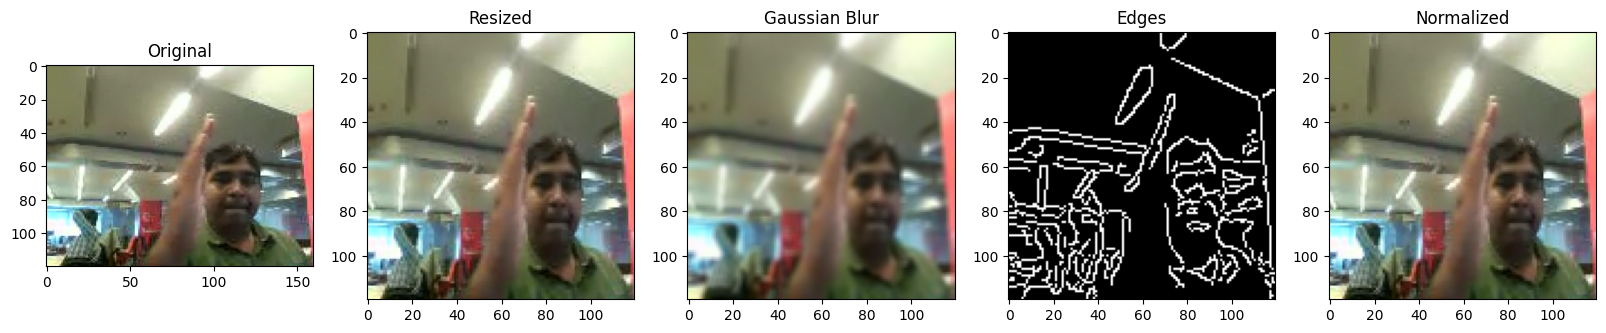

original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


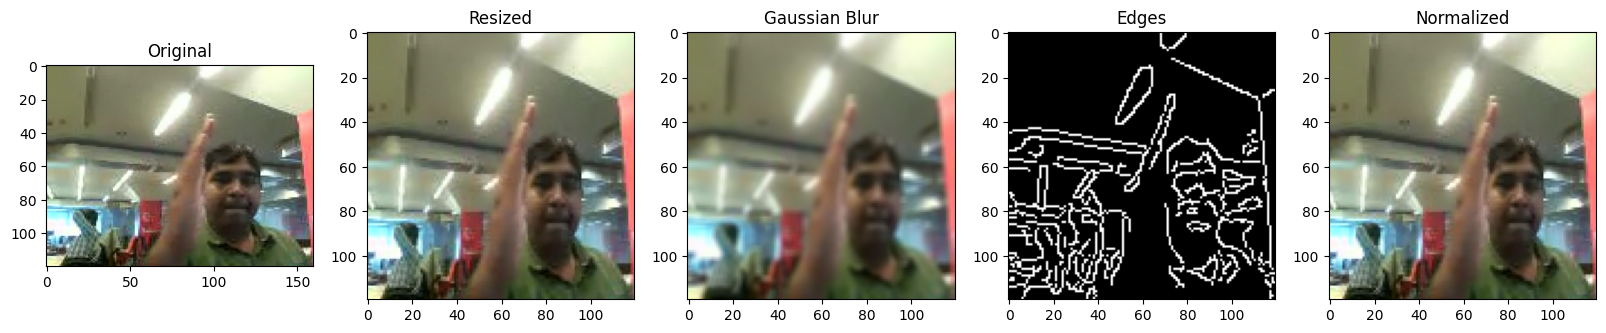

Sample Image for Swipe Right:
original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


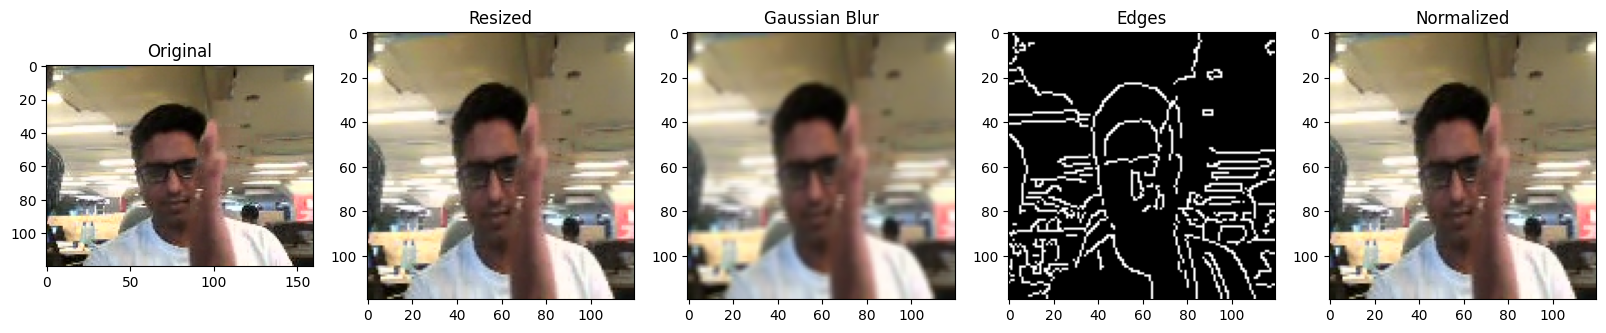

original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


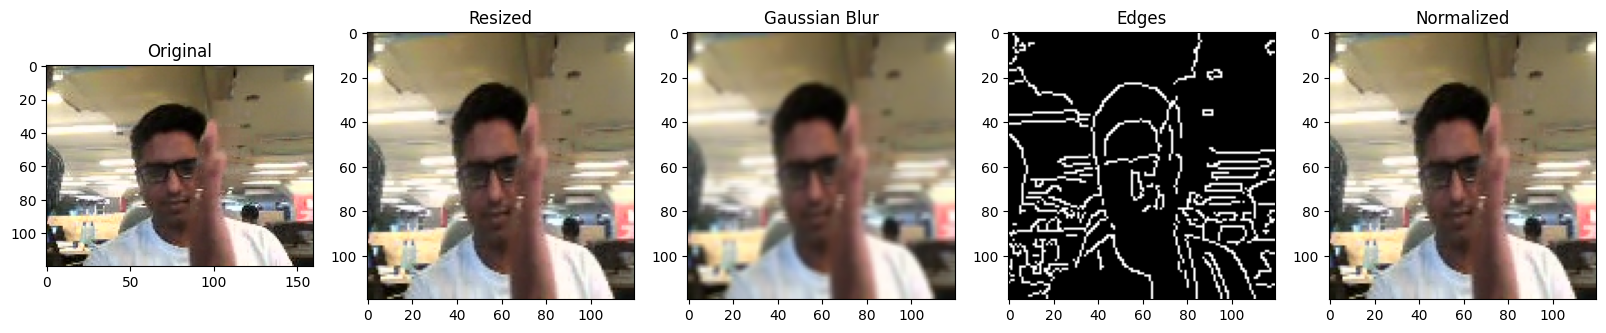

Sample Image for Stop:
original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


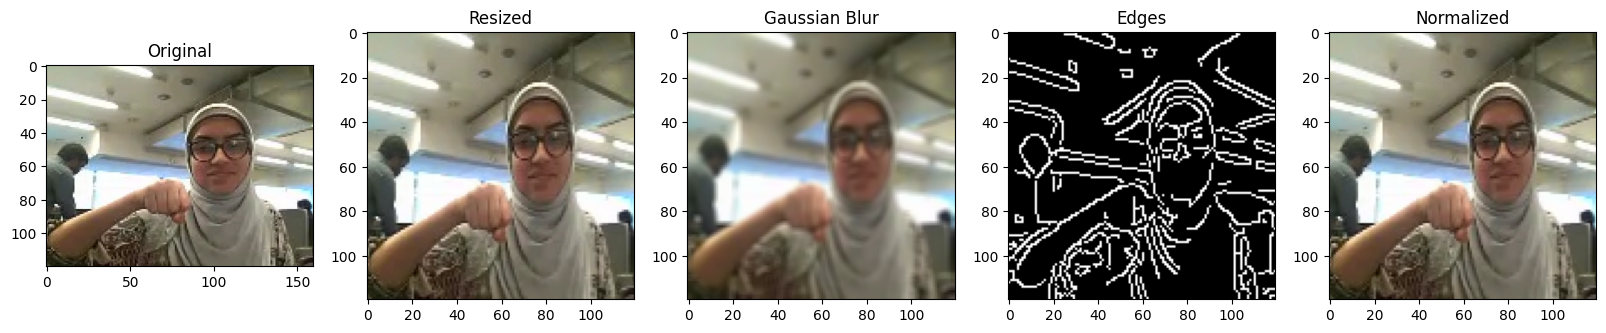

original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


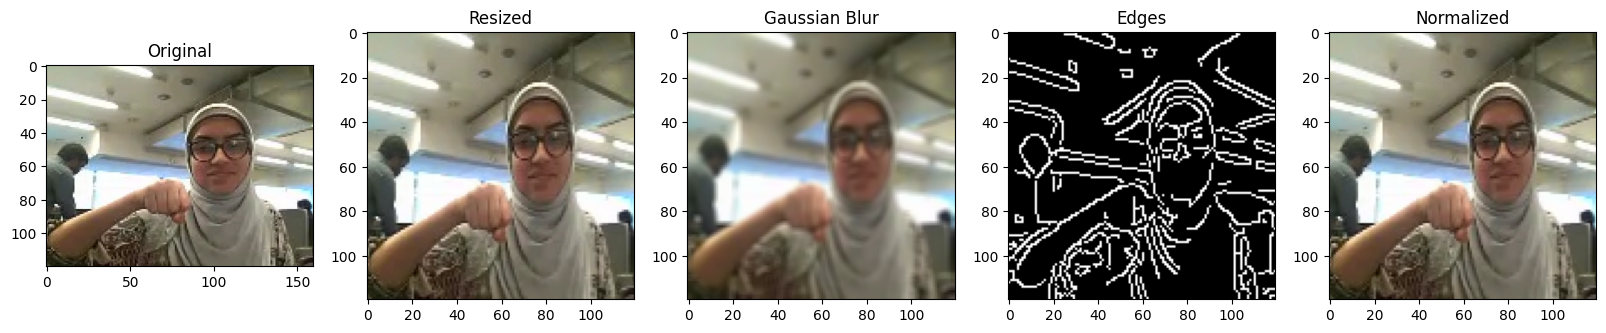

Sample Image for Volume Down:
original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


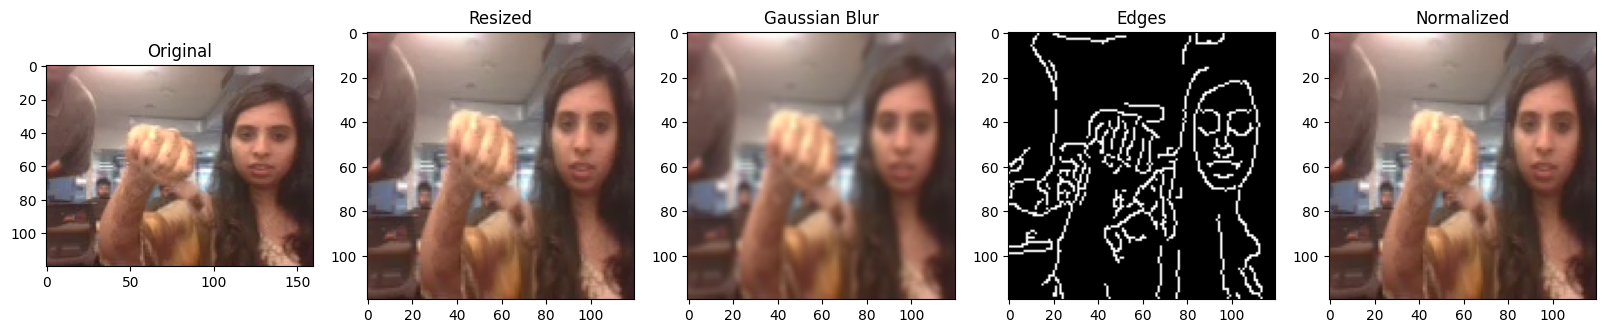

original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


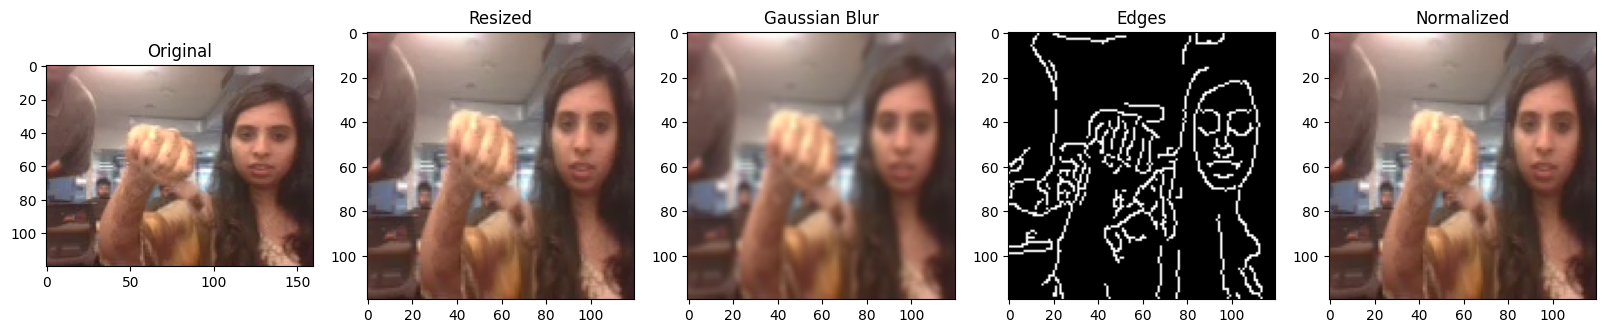

Sample Image for Volume Up:
original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


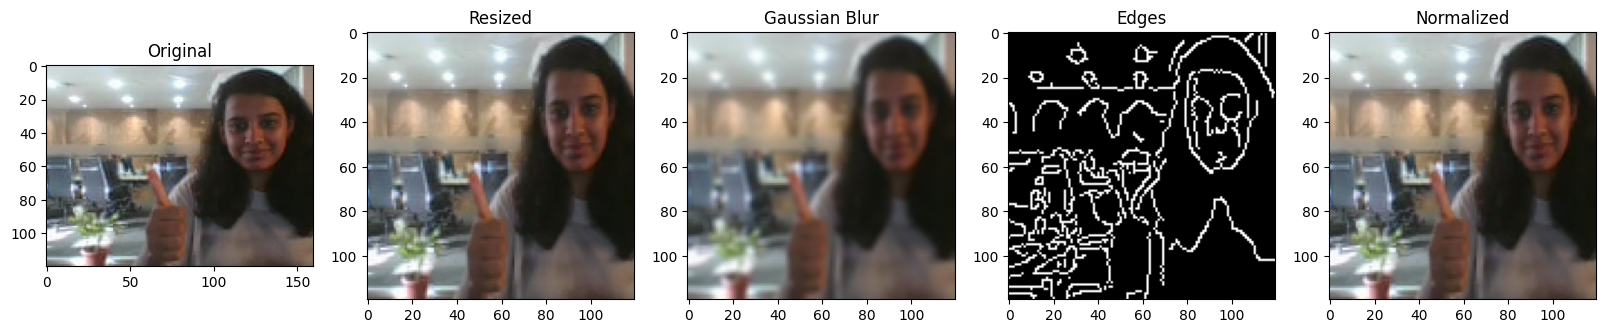

original: (120, 160, 3)
resized: (120, 120, 3)
blurred: (120, 120, 3)
edge: (120, 120, 3)
normalized: (120, 120, 3)


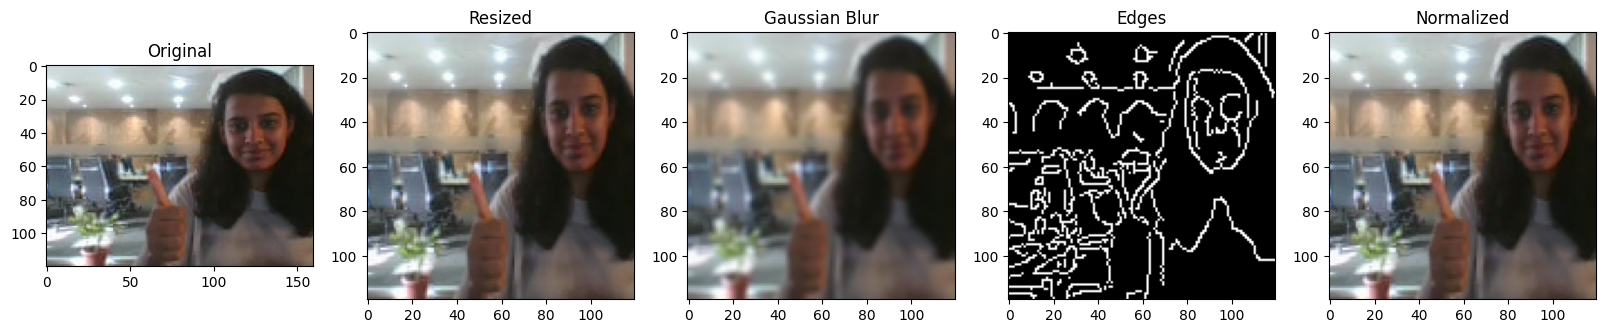

In [17]:
# View the images with their augmented outputs

print('Sample Image for Swipe Left:')
imageview(class_0_120, train_dir)
imageview(class_0_360, train_dir)

print('Sample Image for Swipe Right:')
imageview(class_1_120, train_dir)
imageview(class_1_360, train_dir)

print('Sample Image for Stop:')
imageview(class_2_120, train_dir)
imageview(class_2_360, train_dir)

print('Sample Image for Volume Down:')
imageview(class_3_120, train_dir)
imageview(class_3_360, train_dir)

print('Sample Image for Volume Up:')
imageview(class_4_120, train_dir)
imageview(class_4_360, train_dir)

In [10]:
train_doc = np.random.permutation(open('/kaggle/input/project-data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/kaggle/input/project-data/Project_data/val.csv').readlines())
batch_size = 8

curr_dt_time = datetime.datetime.now()
train_path = train_dir
val_path = val_dir
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20  # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Generator
This is one of the most important part of the code.
 The overall structure of the generator has been given.
 
In the generator, we are going to preprocess the images as we have images of 2 different dimensions as well as create a batch of video frames. 

We are going to experiment with various models going forth to get high accuracy.

In [2]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx =  [x for x in range(0,30)]  
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list) // batch_size    
        for batch in range(num_batches):     
            batch_data = np.zeros((batch_size,len(img_idx),120,120,3))   
            batch_labels = np.zeros((batch_size,5))                                
            for folder in range(batch_size):                                         
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
                for idx,item in enumerate(img_idx):         
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image= resize(image,[120,120])
                    
                    
                    batch_data[folder,idx,:,:,0] = (image[:, : , 0] - np.percentile(image[:, : , 0],5))/ (np.percentile(image[:, : , 0],95) - np.percentile(image[:, : , 0],5))
                    batch_data[folder,idx,:,:,1] = (image[:, : , 1] - np.percentile(image[:, : , 1],5))/ (np.percentile(image[:, : , 1],95) - np.percentile(image[:, : , 1],5))
                    batch_data[folder,idx,:,:,2] = (image[:, : , 2] - np.percentile(image[:, : , 2],5))/ (np.percentile(image[:, : , 2],95) - np.percentile(image[:, : , 2],5))
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels 

        
        if (len(folder_list))> batch_size*num_batches:
            batch=(len(folder_list) // batch_size)
            remaining_folders = len(folder_list)- ((len(folder_list) // batch_size)*batch_size)   
            batch_data = np.zeros((remaining_folders,len(img_idx),120,120,3)) 
            batch_labels = np.zeros((remaining_folders,5)) 
            for folder in range(remaining_folders): 
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
                for idx,item in enumerate(img_idx): 
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image= resize(image,[120,120])
                    
                    
                    batch_data[folder,idx,:,:,0] = (image[:, : , 0] - np.percentile(image[:, : , 0],5))/ (np.percentile(image[:, : , 0],95) - np.percentile(image[:, : , 0],5))
                    batch_data[folder,idx,:,:,1] = (image[:, : , 1] - np.percentile(image[:, : , 1],5))/ (np.percentile(image[:, : , 1],95) - np.percentile(image[:, : , 1],5))
                    batch_data[folder,idx,:,:,2] = (image[:, : , 2] - np.percentile(image[:, : , 2],5))/ (np.percentile(image[:, : , 2],95) - np.percentile(image[:, : , 2],5))
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

In [12]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
#from keras.optimizers import Adam

# Model
Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Model 1

In [21]:
Input_shape = (30, 120, 120, 3)
model = Sequential()
model.add(Conv3D(32, (2,2,2),input_shape=Input_shape,activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))

model.add(Conv3D(64, (2,2,2),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
#model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(256,activation='relu'))
#model.add(Activation('relu'))
model.add(Dropout(0.4))


model.add(Dense(5))
model.add(Activation('softmax'))

In [22]:
model.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 29, 119, 119, 32)  800       
                                                                 
 batch_normalization (BatchN  (None, 29, 119, 119, 32)  128      
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 14, 59, 59, 32)   0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 59, 59, 32)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 13, 58, 58, 64)    16448     
                                                                 
 batch_normalization_1 (Batc  (None, 13, 58, 58, 64)   2

In [23]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [24]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, cooldown=1, verbose=1)     # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [25]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [26]:
batch_size

8

In [5]:
batch_size

8

In [28]:
#% matplotlib inline
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)



Source path =  /kaggle/input/project-data/Project_data/train ; batch size = 8


/tmp/ipykernel_31/18494867.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 50.6412 - categorical_accuracy: 0.2142Source path =  /kaggle/input/project-data/Project_data/val ; batch size = 8

Epoch 1: saving model to model_init_2023-05-1311_57_10.416892/model-00001-50.64121-0.21418-48.67606-0.22000.h5
83/83 [==============================] - 433s 5s/step - loss: 50.6412 - categorical_accuracy: 0.2142 - val_loss: 48.6761 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 10.6968 - categorical_accuracy: 0.2730
Epoch 2: saving model to model_init_2023-05-1311_57_10.416892/model-00002-10.69683-0.27300-141.72128-0.21000.h5
83/83 [==============================] - 346s 4s/step - loss: 10.6968 - categorical_accuracy: 0.2730 - val_loss: 141.7213 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 3.9933 - categorical_accuracy: 0.2217
Epoch 3: saving model to model_init_2023-0

#### Experimenting with Image resolution, number of frames to use and batch_size
When we ran with 160*160 image resolution with 30 frames and batch size of 40, 
we had hit the limit on memory resources. 
Error: ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

-We could see here that "image resolution" and number of frames in sequence have more impact on training time than batch_size. -We could consider the Batch Size around 15-40 for our models. 
-We will change the resoulution 160 * 160, 120 * 120 according to the model performance.

### Model 2: Cov3D with size 120*120 and batch size 8

In [16]:
batch_size = 16
Input_shape = (30, 120, 120, 3)
model2 = Sequential()
model2.add(Conv3D(32, (2,2,2),input_shape=Input_shape,activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2,2,2)))
model2.add(Dropout(0.25))

model2.add(Conv3D(64, (2,2,2),activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling3D(pool_size=(2,2,2)))
model2.add(Dropout(0.25))

model2.add(Flatten())

model2.add(Dense(128,activation='relu'))
#model.add(Activation('relu'))
model2.add(Dropout(0.4))

model2.add(Dense(256,activation='relu'))
#model.add(Activation('relu'))
model2.add(Dropout(0.4))


model2.add(Dense(5))
model2.add(Activation('softmax'))

model2.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 29, 119, 119, 32)  800       
                                                                 
 batch_normalization (BatchN  (None, 29, 119, 119, 32)  128      
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 14, 59, 59, 32)   0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 59, 59, 32)    0         
                                                                 
 conv3d_1 (Conv3D)           (None, 13, 58, 58, 64)    16448     
                                                                 
 batch_normalization_1 (Batc  (None, 13, 58, 58, 64)   2

In [18]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, cooldown=1, verbose=1)     # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [24]:
model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

/tmp/ipykernel_32/2560060529.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential/max_pooling3d/MaxPool3D/MaxPool3DGrad' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/opt/conda/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_32/2560060529.py", line 1, in <module>
      model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 2604, in fit_generator
      return self.fit(
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1027, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 526, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "/opt/conda/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 259, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/sequential/max_pooling3d/MaxPool3D/MaxPool3DGrad'
OOM when allocating tensor with shape[64,32,29,119,119] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential/max_pooling3d/MaxPool3D/MaxPool3DGrad}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_18967]

##### We could see ResourceExhaustedError (OOM error) here suggesting this model would not fly.
Now we ran a few model with more variations of batch, epochs and filters and we could see model is not generlising still and at times overfitting. Validation accurary is also not optimal.


#### Model 6:
#### Decreased batch size to 8 and increased the pooling size and kernel size (from (2,2,2) to (3,3,3)) to address the overfitting issue.

In [13]:
batch_size = 8
# 16,32,64 kernels in 3 consecutive conv3D layers
model6 = Sequential()
# 1st Layer Group
model6.add(Conv3D(16, kernel_size=(3,3,3), input_shape=(30,120,120,3),padding='same'))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(MaxPooling3D(pool_size=(3,3,3)))
# 2nd Layer Group
model6.add(Conv3D(32, kernel_size=(3,3,3),padding='same'))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(MaxPooling3D(pool_size=(3,3,3)))
model6.add(layers.Dropout(0.25))
# 3rd Layer Group
model6.add(Conv3D(64, kernel_size=(3,3,3),padding='same'))
model6.add(BatchNormalization())
model6.add(Activation('relu'))
model6.add(MaxPooling3D(pool_size=(3,3,3)))

# FC layer group
model6.add(Flatten())
model6.add(Dense(500, activation='relu'))
model6.add(layers.Dropout(0.5))
# Softmax Layer
model6.add(Dense(5, activation='softmax'))

In [14]:
model6.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model6.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16)  1312      
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 16)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 40, 40, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 40, 40, 32)    13856     
                                                                 
 batch_normalization_1 (Batc  (None, 10, 40, 40, 32)   1

In [15]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, cooldown=1, verbose=1)     # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]

In [16]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [19]:
model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

/tmp/ipykernel_31/514209202.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model6.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /kaggle/input/project-data/Project_data/train ; batch size = 8
Epoch 1/20
83/83 [==============================] - ETA: 0s - loss: 2.7440 - categorical_accuracy: 0.2685Source path =  /kaggle/input/project-data/Project_data/val ; batch size = 8

Epoch 1: saving model to model_init_2023-05-1405_39_50.299121/model-00001-2.74400-0.26848-1.84921-0.22000.h5
83/83 [==============================] - 381s 4s/step - loss: 2.7440 - categorical_accuracy: 0.2685 - val_loss: 1.8492 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
83/83 [==============================] - ETA: 0s - loss: 1.4459 - categorical_accuracy: 0.3741
Epoch 2: saving model to model_init_2023-05-1405_39_50.299121/model-00002-1.44592-0.37406-2.77928-0.21000.h5
83/83 [==============================] - 275s 3s/step - loss: 1.4459 - categorical_accuracy: 0.3741 - val_loss: 2.7793 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
83/83 [==============================] - ETA: 0s - loss: 1.3199 - categ

### The above model has been selected as the best model since it gives the best train and validation accuracy obtained at epoch 18 with 93.9% training accuracy and 89% validation accuracy. Total params: 585,981

## Model 7 - Using LSTM
## CNN + RNN Architecture

In [32]:
batch_size = 32

model7 = Sequential()

model7.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(30,120,120,3)))
model7.add(TimeDistributed(BatchNormalization()))
model7.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model7.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model7.add(TimeDistributed(BatchNormalization()))
model7.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model7.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model7.add(TimeDistributed(BatchNormalization()))
model7.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model7.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model7.add(TimeDistributed(BatchNormalization()))
model7.add(TimeDistributed(MaxPooling2D((2, 2))))
          

model7.add(TimeDistributed(Flatten()))

model7.add(Dropout(0.25))
model7.add(LSTM(64))
model7.add(Dropout(0.5))
        
        
model7.add(Dense(5, activation='softmax'))

In [33]:
model7.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model7.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 120, 120, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 120, 120, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 60, 60, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 60, 60, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 60, 60, 32)  

In [34]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, cooldown=1, verbose=1)     # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [35]:
model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /kaggle/input/project-data/Project_data/train ; batch size = 32


/tmp/ipykernel_31/2006169261.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model7.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6301 - categorical_accuracy: 0.2760 Source path =  /kaggle/input/project-data/Project_data/val ; batch size = 32

Epoch 1: val_loss improved from inf to 1.59960, saving model to model_init_2023-05-1314_49_23.788400/model-00001-1.63009-0.27602-1.59960-0.30000.h5
21/21 [==============================] - 316s 15s/step - loss: 1.6301 - categorical_accuracy: 0.2760 - val_loss: 1.5996 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.4044 - categorical_accuracy: 0.4510 
Epoch 2: val_loss did not improve from 1.59960
21/21 [==============================] - 327s 16s/step - loss: 1.4044 - categorical_accuracy: 0.4510 - val_loss: 1.6986 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.2702 - categorical_accuracy: 0.4796 
Epoch 3: val_loss did not improve from 1.59960
21/21 [=================

##### categorical_accuracy: 0.8974 which is good. But val_categorical_accuracy: 0.4200.
##### Hence model seems to be overfitting.

### Model 8 - Using GRU
Tweaked layers of above architecture by keeping 3 Conv2D layer (16,32,64) and a GRU layer (64) along with the time distributed layer, Batch Normalization, Dropouts and Max Poling layer.


In [36]:
batch_size =64

model8 = Sequential()

model8.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(30,120,120,3)))
model8.add(TimeDistributed(BatchNormalization()))
model8.add(TimeDistributed(MaxPooling2D((3, 3))))
        
model8.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model8.add(TimeDistributed(BatchNormalization()))
model8.add(TimeDistributed(MaxPooling2D((3, 3))))
        
model8.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model8.add(TimeDistributed(BatchNormalization()))
model8.add(TimeDistributed(MaxPooling2D((3, 3))))
                 

model8.add(TimeDistributed(Flatten()))


model8.add(GRU(64))
model8.add(Dropout(0.5))
        
        
model8.add(Dense(5, activation='softmax'))

In [37]:
model8.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model8.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_13 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_14 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 30, 40, 40, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 30, 40, 40, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 30, 40, 40, 32)  

In [38]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, cooldown=1, verbose=1)     # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [39]:
model8.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

Source path =  /kaggle/input/project-data/Project_data/train ; batch size = 64


/tmp/ipykernel_31/879381185.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model8.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 2.0083 - categorical_accuracy: 0.2730 Source path =  /kaggle/input/project-data/Project_data/val ; batch size = 64

Epoch 1: val_loss improved from inf to 1.59937, saving model to model_init_2023-05-1314_49_23.788400/model-00001-2.00834-0.27300-1.59937-0.23000.h5
11/11 [==============================] - 325s 32s/step - loss: 2.0083 - categorical_accuracy: 0.2730 - val_loss: 1.5994 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.5350 - categorical_accuracy: 0.3846 
Epoch 2: val_loss improved from 1.59937 to 1.59187, saving model to model_init_2023-05-1314_49_23.788400/model-00002-1.53499-0.38462-1.59187-0.23000.h5
11/11 [==============================] - 327s 33s/step - loss: 1.5350 - categorical_accuracy: 0.3846 - val_loss: 1.5919 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/20
11/11 [==============================] - ETA: 0s - loss: 1.302

##### categorical_accuracy: 0.8899. val_categorical_accuracy: 0.2400.  Again model is overfitting.

### Model 9 - Using Transfer Learning - Mobilenet

In [18]:
#Use Transfer Learning MobileNet
from tensorflow.keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

#Make weight of the transer model trainable false
mobilenet_transfer.trainable = False

17225924/17225924 [==============================] - 0s 0us/step


In [19]:
batch_size = 64
model10 = Sequential()
model10.add(TimeDistributed(mobilenet_transfer,input_shape=(30,120,120,3)))
        
model10.add(TimeDistributed(BatchNormalization()))
model10.add(TimeDistributed(MaxPooling2D((2, 2))))
model10.add(TimeDistributed(Flatten()))

model10.add(GRU(64))
model10.add(Dropout(0.5))
        
model10.add(Dense(64,activation='relu'))
model10.add(Dropout(0.5))
        
model10.add(Dense(5, activation='softmax'))

In [21]:
model10.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model10.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 3, 3, 1024)   3228864   
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 3, 3, 1024)   4096      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 1, 1, 1024)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 1024)         0         
 tributed)                                                       
                                                                 
 gru (GRU)                   (None, 64)               

In [22]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, cooldown=1, verbose=1)     # write the REducelronplateau code here
callbacks_list = [checkpoint, LR]


if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [23]:
model10.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, initial_epoch=0)

/tmp/ipykernel_32/436822440.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model10.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path =  /kaggle/input/project-data/Project_data/train ; batch size = 64
Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.9504 - categorical_accuracy: 0.2051 Source path =  /kaggle/input/project-data/Project_data/val ; batch size = 64

Epoch 1: val_loss improved from inf to 1.58318, saving model to model_init_2023-05-1400_54_37.867129/model-00001-1.95042-0.20513-1.58318-0.23000.h5
11/11 [==============================] - 392s 37s/step - loss: 1.9504 - categorical_accuracy: 0.2051 - val_loss: 1.5832 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.6125 - categorical_accuracy: 0.3167 
Epoch 2: val_loss improved from 1.58318 to 1.48302, saving model to model_init_2023-05-1400_54_37.867129/model-00002-1.61248-0.31674-1.48302-0.35000.h5
11/11 [==============================] - 295s 29s/step - loss: 1.6125 - categorical_accuracy: 0.3167 - val_loss: 1.4830 - val_categorical_accuracy: 0.3500 - lr: 0

#### Here categorical_accuracy: 0.9487, val_categorical_accuracy: 0.7500. There is lot of variation in training and validation result.

### After doing all the experiments, we finalized Model 6 which performed well.

#### This model has been selected as the best model since it gives the best train and validation accuracy obtained at epoch 18 with 93.9% training accuracy and 89% validation accuracy.  Total params: 585,981  which is really good as comparision to other models.
#### In this model, we decreased batch size further to 8 and increased the pooling size and kernel size (from (2,2,2) to (3,3,3)) to address the overfitting issue. 

#### The best weights of CNN-LSTM: model-00020-0.31499-0.89593-0.51612-0.83000.h5. 
#### We are considering this to calculate the accuracy on the test data.


### Loading model and Testing

In [4]:
import time
from keras.models import load_model

# load model
model = load_model('model-00020-0.31499-0.89593-0.51612-0.83000.h5')
# summarize model.
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16)  1312      
                                                                 
 batch_normalization (BatchN  (None, 30, 120, 120, 16)  64       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 30, 120, 120, 16)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 40, 40, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 40, 40, 32)    13856     
                                                                 
 batch_normalization_1 (Batc  (None, 10, 40, 40, 32)   1

In [5]:
# Testing the model using a sample random image from the validation data set.

# Filtering one random image from validation data set
sample_img = generator(val_path, val_doc, batch_size = 2)
sample_img_data, sample_img_label = next(sample_img)

# Actual Class from the sample image
print('Actual Class of the Image: ', list(sample_img_label[0]).index(1))

# Predicted Class from the model
print('Predicted Class of the Image: ', np.argmax(model.predict(sample_img_data), axis = 1)[0])

Source path =  ../../Project_data/val/ ; batch size = 2


/var/folders/6y/qbtk58qn6xzg2hg96358lmd80000gn/T/ipykernel_15332/430137478.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)


Actual Class of the Image:  3
1/1 [==============================] - 0s 269ms/step
Predicted Class of the Image:  3
